In [1]:
# Intorduction:
#   This repository contains a Python-based simulation framework for evaluating the effects of coefficient and output quantization on IIR filters. 
#   It compares floating-point and fixed-point implementations, providing insights into quantization-induced errors through both theoretical analysis and empirical simulation.
# Author:
#   Siqi Hui
# Version history:
#   1.0.0: initial version with basic functionality, including: 
#     - IIR filter design and implementation
#     - quantization of filter coefficients and outputs
#     - simulation of quantization errors
#   1.0.1: added support for highpass filters
#   1.0.2: added noise level parameter to simulate real-world conditions    
#   1.0.3: added simulation for mean quantization errors in different frequency bands
#   1.0.4: modify iir's ouput to be quantized by np.floor(y)+1, which is more suitable for fixed-point implementation
#   1.0.5: add software-base optimized method

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal


In [3]:
# quant iir
class QuantizedIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2, iir_coeff_bit, feedback_half_lsb=False):
        # 系数量化
        coeff_quant_factor = 1/(2**iir_coeff_bit)
        self.b0 = np.round(b0 / coeff_quant_factor)
        self.b1 = np.round(b1 / coeff_quant_factor)
        self.b2 = np.round(b2 / coeff_quant_factor)
        self.a1 = np.abs(np.round(a1 / coeff_quant_factor))
        self.a2 = np.abs(np.round(a2 / coeff_quant_factor))
        self.feedback_half_lsb = feedback_half_lsb
        
        # 中间w1 w2缓存
        self.w1 = 0
        self.w2 = 0
        
        # 系数量化银子
        self.coeff_quant_factor = coeff_quant_factor
        # 输出量化因子
        self.max_w0 = 0
    
    def process(self, x):
        # w0 = 1.0 * x + np.floor((self.w1 * self.a1 -self.w2 * self.a2) * self.coeff_quant_factor)# 噪声偏大
        w0 = 1.0 * x - np.floor((self.w2 * self.a2 - self.w1 * self.a1) * self.coeff_quant_factor) # 噪声更小哎
        self.max_w0 = max(self.max_w0, w0)
        
        # 这里发现一个小技巧，对于舍掉的小数，前面去反，可以改善噪声
        y = 1.0 * (self.b0 * w0 + self.b1 * self.w1  + self.b2 * self.w2) * self.coeff_quant_factor
        y = np.floor(y)
        self.w2 = self.w1
        self.w1 = w0
        
        return y

In [4]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [5]:
def signal_generator(fs, time, signal_range, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    return generated_signal

In [6]:
def analyze_quantization_error(x, fc_fs_ratio, iir_coeff_bit, fs=10000, start_freq = 1, end_freq = 2500,
                               signal_range=10000, noise_level=0, btype='low', feedback_half_lsb=False, float_iir_use_quant_coeff=True):
    """
    输入：
        x: 输入信号(1D numpy 数组)
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        fs: 采样率(默认10000)
        signal_range: 信号幅度缩放因子(默认10000)
        noise_level: 添加的噪声水平(默认0, 不添加噪声, 1~10的整数表示添加1~10个lsb的量化噪声)
        btype: 滤波器类型('low'表示低通滤波器, 'high'表示高通滤波器)
        feedback_half_lsb: 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈(默认False)
    """
    # 设计滤波器
    fc = fc_fs_ratio * fs
    b, a = butter(2, fc / (fs / 2), btype=btype)

    quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, feedback_half_lsb)
    # 这里可以选择是否使用量化系数来初始化浮点IIR
    if float_iir_use_quant_coeff:
        quant_scale = 1 / (2**iir_coeff_bit)
        b[0], b[1], b[2], a[1], a[2] = quant_iir.b0*quant_scale, quant_iir.b1*quant_scale, quant_iir.b2*quant_scale, -quant_iir.a1*quant_scale, quant_iir.a2*quant_scale
    
    float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
    y_quantized = np.array([quant_iir.process(sample) for sample in x])
    print(quant_iir.max_w0)

    # 添加噪声
    if noise_level > 0:
        noise = np.random.uniform(0, 1, len(x))
        x = x + noise
    y_float = np.array([float_iir.process(sample) for sample in x])

    # 计算量化误差
    quant_error = y_quantized - y_float

    # 误差计算
    gain = 1 / sum(a)

    print(f"revise gain: {gain}")
    print(f"quant_error_empirical_max: {np.max(np.abs(quant_error)):.3g}")
    print(f"quant_error_empirical_mean: {np.mean(np.abs(quant_error)):.3g}")

    # 计算谐振频率和Q因子
    # get_resonant_freq(fs, quant_iir.b0, quant_iir.b1, quant_iir.b2, quant_iir.a1, quant_iir.a2)

    # 频率标尺
    total_time = len(x) // fs
    t = np.linspace(0, total_time, len(x), endpoint=False)

    # the same with signal_generator
    freq_ticks = [start_freq + (end_freq - start_freq) * (i / total_time) for i in range(0, total_time + 1, 10)]
    time_ticks = [i for i in range(0, total_time + 1, 10)]

    # === 计算每 fs 点内的平均绝对误差 ===
    quant_error_abs = np.abs(quant_error)
    window_size = fs
    mean_abs_error_per_window = [
        np.mean(quant_error_abs[i:i + window_size])
        for i in range(0, len(quant_error_abs), window_size)
    ]
    window_time = np.arange(len(mean_abs_error_per_window))

    # === 绘图 ===
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    ax1 = axes[0]
    ax1.plot(t, y_quantized, label="y_quantized", color='b')
    ax1.set_xticks(time_ticks)
    ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('y_quantized', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend()
    ax1.set_title("Quantized Output Signal")
    ax1.grid(True)

    ax2 = axes[1]
    ax2.plot(t, quant_error, label="quant_error", color='r')
    ax2.set_xticks(time_ticks)
    ax2.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Quantization Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend()
    ax2.set_title("Quantization Error")
    ax2.grid(True)

    ax3 = axes[2]
    ax3.plot(window_time, mean_abs_error_per_window, label="mean_abs_error/fs", color='g')
    ax3.set_xticks(time_ticks)
    ax3.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Mean Absolute Error', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend()
    ax3.set_title("Mean Absolute Quantization Error per fs window")
    ax3.grid(True)

    plt.suptitle(
        f"Effect of Quantization, fc/fs: {fc_fs_ratio}, "
        f"Coeffs bitwidth: {iir_coeff_bit}, noise_level: {noise_level}, filter bandtype: {btype}, "
        f"feedback_half_lsb: {feedback_half_lsb}, float_iir_use_quant_coeff: {float_iir_use_quant_coeff}",
        fontsize=14
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
# 计算给定截止频率比例和系数量化位宽下的滤波器量化误差(系数的量化误差会随频率变化而变化)
def calc_quant_error(fc_fs_ratio, fs=10000, btype='low',
                     b_bit=20, a_bit=19, signal_range=16384, verbose=False):
    """
    计算给定截止频率比例和系数量化位宽下的滤波器量化误差

    参数
    ----
    fc_fs_ratio : float
        截止频率与采样率之比 (fc / fs)
    fs : float, optional
        采样率（默认 10000）
    btype : str, optional
        滤波器类型 ('low', 'high', 'bandpass', 'bandstop')
    b_bit : int, optional
        分子 (b) 量化位宽
    a_bit : int, optional
        分母 (a) 量化位宽
    signal_range : float, optional
        输入信号量程（用于放大误差）

    返回
    ----
    quant_err : float
        最大幅频响应误差对应的量化误差
    """

    # 计算截止频率
    fc = fc_fs_ratio * fs

    # 设计二阶巴特沃斯滤波器
    b, a = signal.butter(2, fc / (fs / 2), btype=btype)

    # 定点量化
    quant_b_scale = 2 ** b_bit
    quant_a_scale = 2 ** a_bit
    b_q = np.round(b * quant_b_scale) / quant_b_scale
    a_q = np.round(a * quant_a_scale) / quant_a_scale

    # 计算频率响应
    w, h = signal.freqz(b, a)
    w_q, h_q = signal.freqz(b_q, a_q)

    # 量化误差（取最大响应差 × 信号幅度）
    quant_err = signal_range * np.max(np.abs(h - h_q))
    if verbose:
        print("quant_err close pole point: ", quant_err)
    return quant_err

In [8]:
# method 0
def search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=10000, signal_range=16384):
    """
    输入：
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        search_range: 在 fc_fs_ratio 的基础上搜索的范围(1-search_range)*fc_fs_ratio,  (1+search_range) * fc_fs_ratio
        fs: 采样率(默认10000)
    """

    start_fc_fs_ratio = fc_fs_ratio * (1 - search_range)
    end_fc_fs_ratio = fc_fs_ratio * (1 + search_range)
    step = 1e-6
    fc_fs_ratio_list = [start_fc_fs_ratio + i * step for i in range(int(search_range*2*fc_fs_ratio/step))]
    fc_fs_ratio_dict = {} # fc_fs_ratio -> delta_error

    for fc_fs_ratio in fc_fs_ratio_list:
        fc_fs_ratio_dict[fc_fs_ratio] = calc_quant_error(fc_fs_ratio, fs=fs, btype='low', b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=False)
    
    best_fc_fs_ratio = min(fc_fs_ratio_dict, key=fc_fs_ratio_dict.get)
    # print("best_fc_fs_ratio: ", best_fc_fs_ratio)
    # print("b a coeffs err: ", fc_fs_ratio_b_a_dict[best_fc_fs_ratio])

    return best_fc_fs_ratio

original fc_fs_ratio:  0.004
quant_err close pole point:  1560.3333333287987
51193997.0
revise gain: 1611.3602342799372
quant_error_empirical_max: 1.56e+03
quant_error_empirical_mean: 122


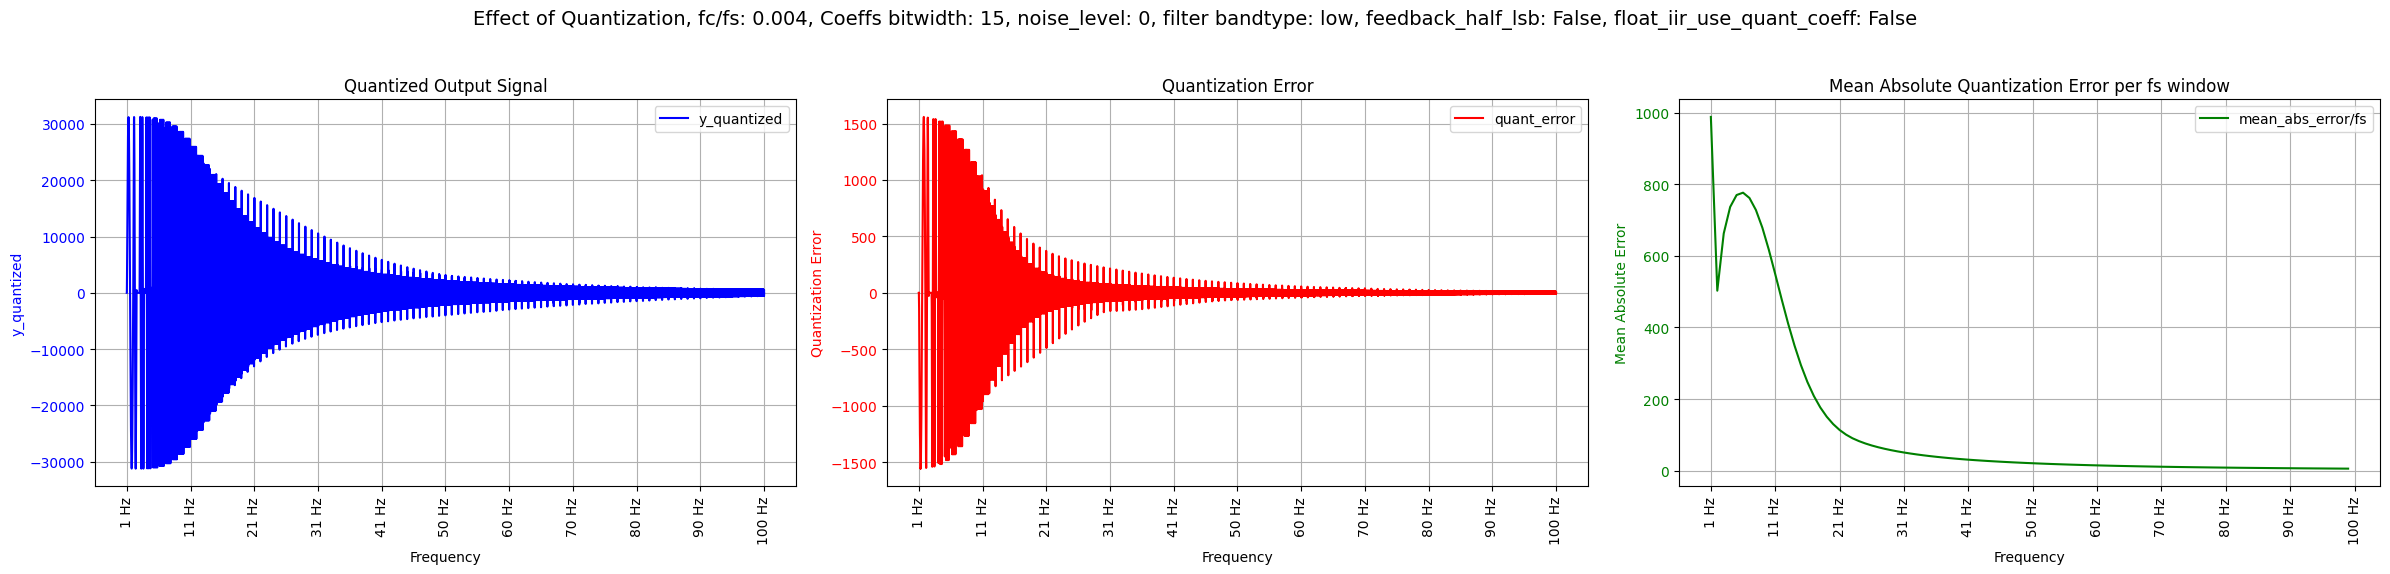

update fc_fs_ratio:  0.003966
quant_err close pole point:  4.7128491759832984
53685162.0
revise gain: 1638.8619600130464
quant_error_empirical_max: 5.26
quant_error_empirical_mean: 0.8


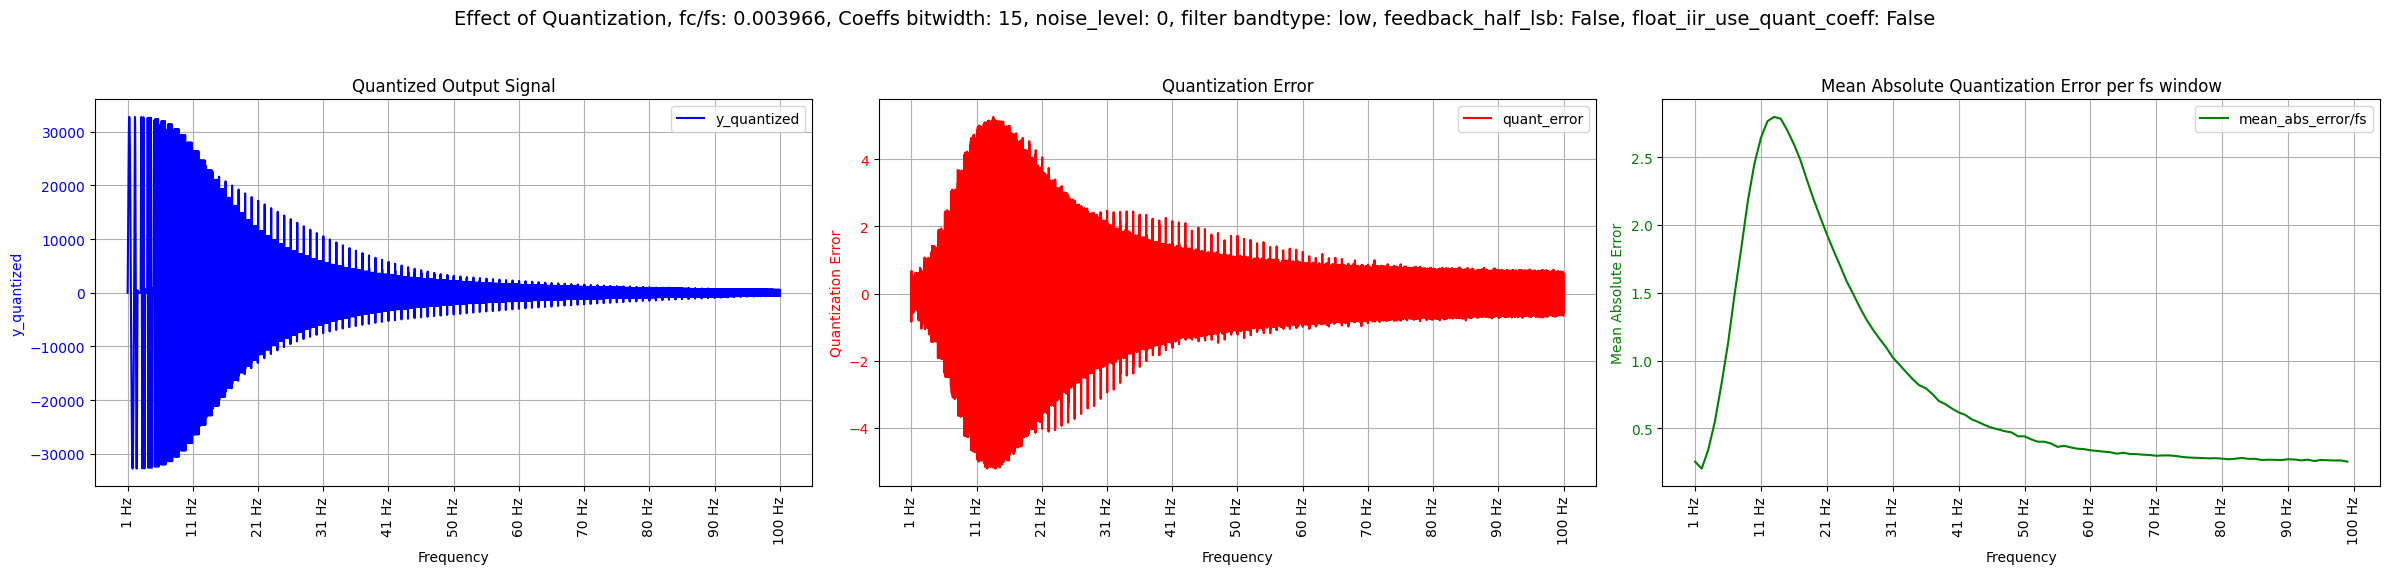

original fc_fs_ratio:  0.0081
quant_err close pole point:  399.5975609762649
13094278.0
revise gain: 400.047822275818
quant_error_empirical_max: 400
quant_error_empirical_mean: 93.1


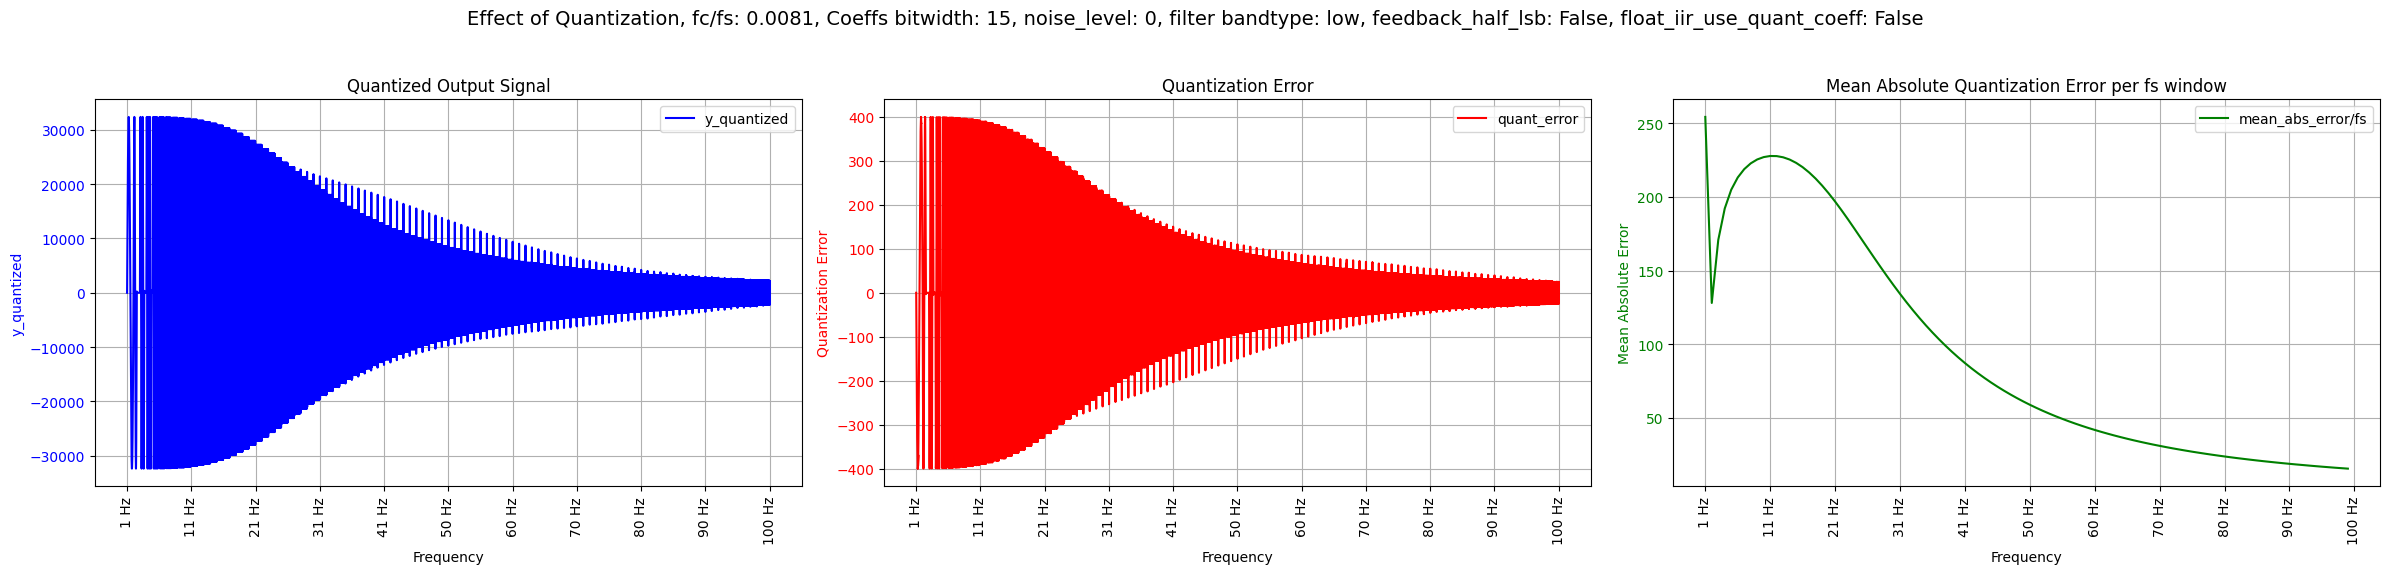

update fc_fs_ratio:  0.008400999999999999
quant_err close pole point:  1.7245746886577016
12201439.0
revise gain: 372.3801999777229
quant_error_empirical_max: 2.27
quant_error_empirical_mean: 0.503


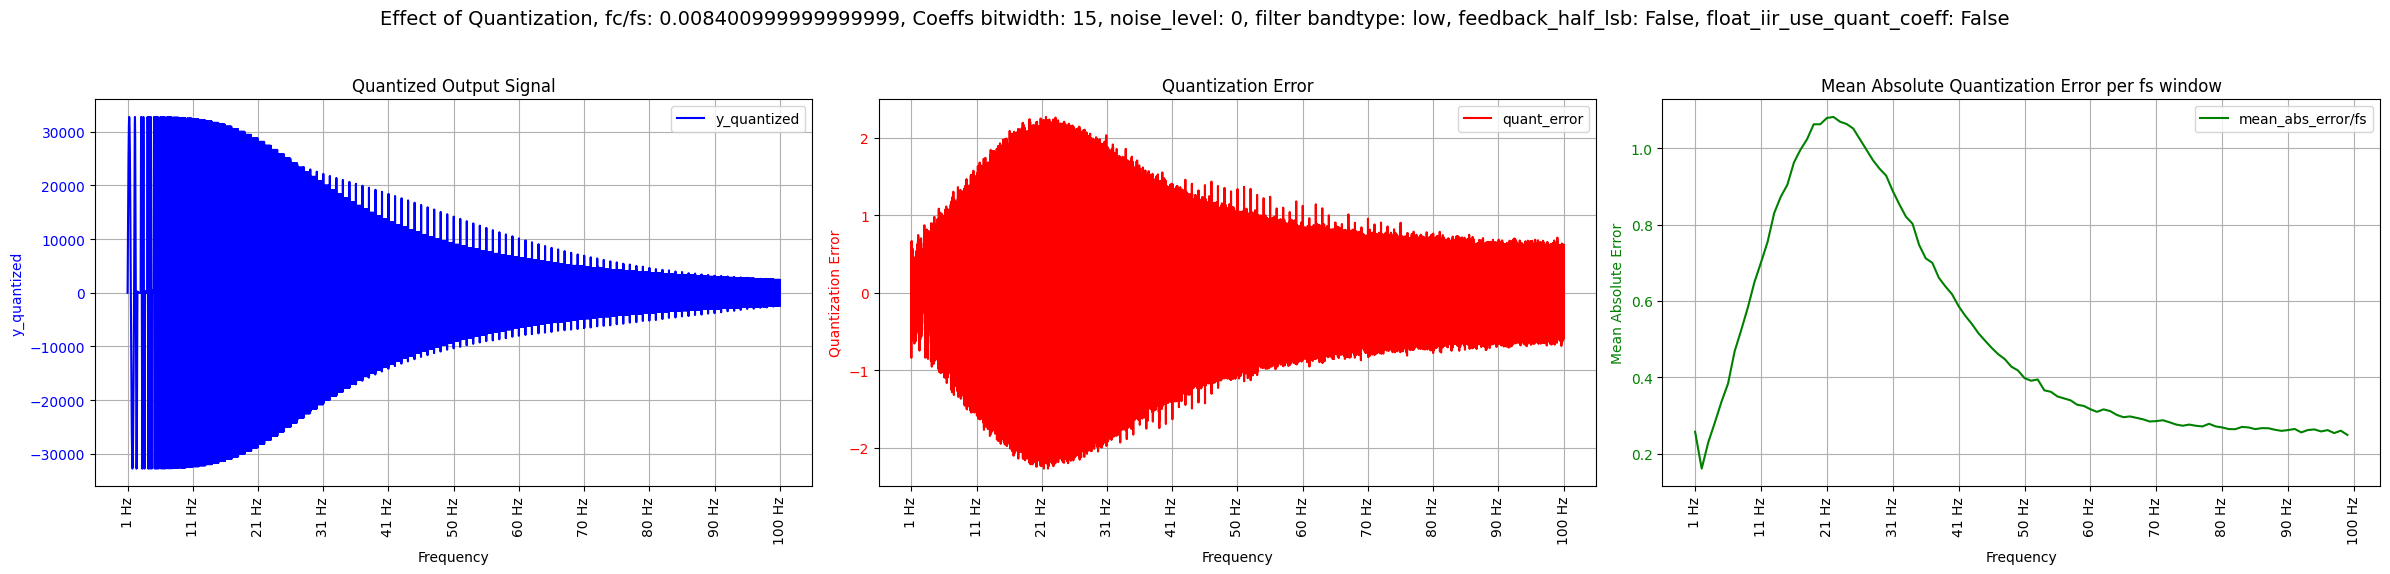

In [9]:
# test cases:
btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
fc_fs_ratio_lists = [0.004, 0.0081] #[0.004, 0.01, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.2, 0.24] 
iir_coeff_bit_lists = [15]
signal_range_list = [32767]
noise_level_list = [0] #[0, 1]
feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
float_iir_use_quant_coeff_list = [False] # [True, False]  # 是否使用量化系数来初始化浮点IIR

# signal generator params
# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 100     # 终止频率
fs = 3200  # 每秒采样点数
time = 100  # 仿真时间

for btype in btype_lists:
    for signal_range in signal_range_list:
        generated_signal = signal_generator(fs, time, signal_range, start_freq, end_freq)
        for fc_fs_ratio in fc_fs_ratio_lists:
            for iir_coeff_bit in iir_coeff_bit_lists:
                for noise_level in noise_level_list:
                    for feedback_half_lsb in feedback_half_lsb_list:
                        for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
                            # 遍历得到最优的fc_fs
                            # 首先计算原始fc_fs_ratio下的量化误差
                            print("original fc_fs_ratio: ", fc_fs_ratio)
                            initial_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, noise_level=noise_level, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

                            # 调用分析函数
                            # 计算优化后的fc_fs_ratio下的量化误差
                            fc_fs_ratio = search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=fs, signal_range=signal_range)
                            print("update fc_fs_ratio: ", fc_fs_ratio)
                            update_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, noise_level=noise_level, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)